In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN


In [12]:
demand = pd.read_csv("../../data/features/demand_type.csv", encoding="latin1")

In [13]:
# ============================================
# 1) LOAD & TIỀN XỬ LÝ DỮ LIỆU
# ============================================
df = pd.read_csv("../../data/raw/sales_train.csv", encoding="latin1")

In [14]:
df2 = pd.read_csv("../../data/raw/online_retail.csv", encoding="latin1")


df2["InvoiceDate"] = pd.to_datetime(df2["InvoiceDate"], dayfirst=True)

df2["date_block_num"] = (df2["InvoiceDate"].dt.year - 2010) * 12 + (
    df2["InvoiceDate"].dt.month - 1
)

df2["shop_id"] = 0
df2["item_id"] = df2["StockCode"].astype("category").cat.codes

df2_new = (
    df2.groupby(["InvoiceDate", "date_block_num", "shop_id", "item_id"])
    .agg({"UnitPrice": "mean", "Quantity": "sum"})
    .reset_index()
)

df2_new.rename(
    columns={
        "InvoiceDate": "date",
        "UnitPrice": "item_price",
        "Quantity": "item_cnt_day",
    },
    inplace=True,
)

df2_new["date"] = df2_new["date"].dt.strftime("%d.%m.%Y")
df = df2_new.copy()

/var/folders/x8/3s0s9pbj7bgb2h7w5bbd8v7h0000gn/T/ipykernel_27692/836837014.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2["InvoiceDate"] = pd.to_datetime(df2["InvoiceDate"], dayfirst=True)


In [15]:


# ============================================
# 2) TÍNH TRUNG BÌNH BÁN THEO THÁNG CHO TỪNG ITEM
# ============================================

df_sold = df[df["item_cnt_day"] > 0]  # chỉ lấy ngày có bán

item_block_df = df_sold.groupby("item_id")
list_block_num = df["date_block_num"].nunique()

# loại item không có std (ít dữ liệu → noise)
valid_mask = ~item_block_df["item_cnt_day"].std().isna()

valid_items = valid_mask[valid_mask].index

df_valid = df_sold[df_sold["item_id"].isin(valid_items)]

# tính trung bình tháng
avg_df = (
    df_valid.groupby("item_id")[["item_cnt_day", "item_price"]].sum() / list_block_num
)

avg_df.rename(
    columns={"item_cnt_day": "sell_avg_month", "item_price": "price"}, inplace=True
)


In [16]:
# ============================================
# 3) LOẠI OUTLIER BẰNG IQR
# ============================================


def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean


numeric_cols = ["sell_avg_month", "price"]
avg_clean = remove_outliers_iqr(avg_df, numeric_cols)

# ============================================
# 4) GHÉP DEMAND TYPE
# ============================================

filter_df = pd.concat([avg_clean, demand["demand_type"]], axis=1).dropna()
# filter_df = filter_df[filter_df["demand_type"] == 1]

print(filter_df.describe())



       sell_avg_month        price  demand_type
count     2749.000000  2749.000000  2749.000000
mean        29.873392     7.768566     1.444162
std         36.531658     8.211521     0.663204
min          0.090909     0.010909     0.000000
25%          3.181818     1.461818     1.000000
50%         13.954545     4.977727     2.000000
75%         43.909091    11.177727     2.000000
max        162.818182    36.179545     2.000000


In [17]:
# ============================================
# 4.1) LỌC THEO ZERO_RATIO
# ============================================

# Tính mean của zero_ratio
mean_zero_ratio = demand["zero_ratio"].quantile(0.25)

# Lọc ra các item có zero_ratio <= mean (loại item zero_ratio lớn hơn mean)
demand_filtered = demand[demand["zero_ratio"] <= mean_zero_ratio]

print("Mean zero_ratio =", mean_zero_ratio)
print("Số lượng item còn lại =", len(demand_filtered))


demand_filtered = demand_filtered.set_index("item_id")
avg_clean = avg_clean.set_index(avg_clean.index)  # đã là item_id rồi

filter_df = avg_clean.join(demand_filtered[["demand_type", "zero_ratio"]], how="inner")
filter_df = filter_df.dropna()

numeric_cols = ["zero_ratio"]
filter_df = remove_outliers_iqr(filter_df, numeric_cols)

print(filter_df.describe())

# ============================================
# 5) CHUẨN HÓA + DBSCAN
# ============================================

X = filter_df[["sell_avg_month", "price"]].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

dbscan = DBSCAN(eps=0.5, min_samples=10)
clusters = dbscan.fit_predict(X_scaled)

filter_df["demand_type_dbscan"] = clusters

from sklearn.cluster import KMeans

Mean zero_ratio = 0.6426229508196721
Số lượng item còn lại = 951
       sell_avg_month       price  demand_type  zero_ratio
count      336.000000  336.000000        336.0  336.000000
mean        83.444535   16.821803          1.0    0.546224
std         36.762839    9.055126          0.0    0.073198
min         12.818182    2.416818          1.0    0.337705
25%         53.636364    9.223295          1.0    0.504918
50%         82.886364   15.102273          1.0    0.563934
75%        108.829545   24.049773          1.0    0.606557
max        162.409091   36.179545          1.0    0.642623


Silhouette: 0.191954864190927


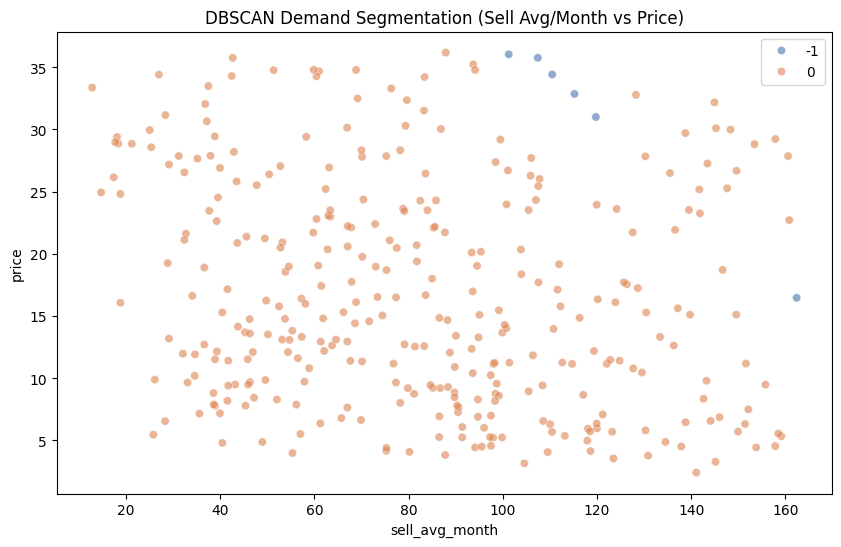

In [18]:

# ============================================
# 5) CHUẨN HÓA + KMEANS
# ============================================

X = filter_df[["sell_avg_month", "price"]].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

filter_df["demand_type_kmeans"] = clusters

from sklearn.metrics import silhouette_score

score = silhouette_score(X, clusters)
print("Silhouette:", score)

# ============================================
# 6) VẼ PHÂN CỤM
# ============================================

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=filter_df,
    x="sell_avg_month",
    y="price",
    hue="demand_type_dbscan",
    palette="deep",
    alpha=0.6,
)
plt.title("DBSCAN Demand Segmentation (Sell Avg/Month vs Price)")
plt.legend()
plt.show()